In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,6]

# 2 The Factors

In [3]:
factors = pd.read_excel('factor_pricing_data.xlsx',sheet_name='factors (excess returns)',index_col='Date')
factors.tail()

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
2023-03-31,0.0251,-0.0694,-0.0885,0.0224,-0.0237,-0.0249
2023-04-30,0.0061,-0.0256,-0.0004,0.0242,0.0286,0.0163
2023-05-31,0.0035,-0.0038,-0.0772,-0.0181,-0.0722,-0.0063
2023-06-30,0.0646,0.0134,-0.0026,0.0218,-0.0162,-0.0239
2023-07-31,0.0321,0.0286,0.0413,-0.0056,0.0062,-0.0406


## 2.1 
### Analyze the factors, similar to how you analyzed the three Fama-French factors in Homework 4. You now have three additional factors, so let’s compare there univariate statistics.<br> • mean <br>• volatility <br> • Sharpe


In [4]:
def summaryStats(df):
    
    summary = pd.DataFrame(index = df.columns)
    
    summary['Mean'] = df.mean()*12
    summary['Volatility'] = df.std()*np.sqrt(12)
    summary['Sharpe Ratio'] = summary['Mean']/summary['Volatility']    
        
    return summary

#### Beginning - 1980

In [5]:
summaryStats(factors[:'1980'])

,Mean,Volatility,Sharpe Ratio
MKT,0.2029,0.203717,0.995990
SMB,0.0537,0.108821,0.493472
HML,-0.1987,0.117754,-1.687412
RMW,0.1078,0.073037,1.475957
CMA,-0.0977,0.076936,-1.269882
UMD,0.3078,0.234594,1.312054


#### 1981 - 2001

In [6]:
summaryStats(factors['1981':'2001'])

,Mean,Volatility,Sharpe Ratio
MKT,0.077257,0.157396,0.490847
SMB,0.001429,0.109605,0.013034
HML,0.063776,0.111183,0.573612
RMW,0.046914,0.091606,0.512130
CMA,0.053157,0.077355,0.687185
UMD,0.101686,0.145105,0.700775


#### 2002 - End

In [7]:
summaryStats(factors['2002':])

,Mean,Volatility,Sharpe Ratio
MKT,0.086187,0.155313,0.554923
SMB,0.018751,0.090739,0.206642
HML,-0.001710,0.107517,-0.015901
RMW,0.043307,0.075282,0.575261
CMA,0.018417,0.068581,0.268543
UMD,0.009827,0.159709,0.061531


## 2.2
### Based on the factor statistics above, answer the following. <br><br> (a) Does each factor have a positive risk premium (positive expected excess return)?

- Prior to 1981, only two factors (`HML` and `CMA`) had negative risk premia.
- After 1981, all the factors, except `HML` since 2002, have positive risk premia.

### (b) How have the factors performed since the time of the case, (2015-present)?


In [8]:
summaryStats(factors['2015':])

,Mean,Volatility,Sharpe Ratio
MKT,0.111705,0.162705,0.686549
SMB,-0.008377,0.098268,-0.085244
HML,-0.025817,0.135825,-0.190080
RMW,0.048594,0.073131,0.664483
CMA,0.001794,0.086965,0.020631
UMD,0.006501,0.144006,0.045144


- The market factor `MKT` performs the best (in terms of risk premium and Sharpe ratio) since 2015. The profitability factor `RMW` ranks the second. However, other factors do not have significant positive risk premia and Sharpe ratios.

## 2.3
### Report the correlation matrix across the six factors.

<Axes: >

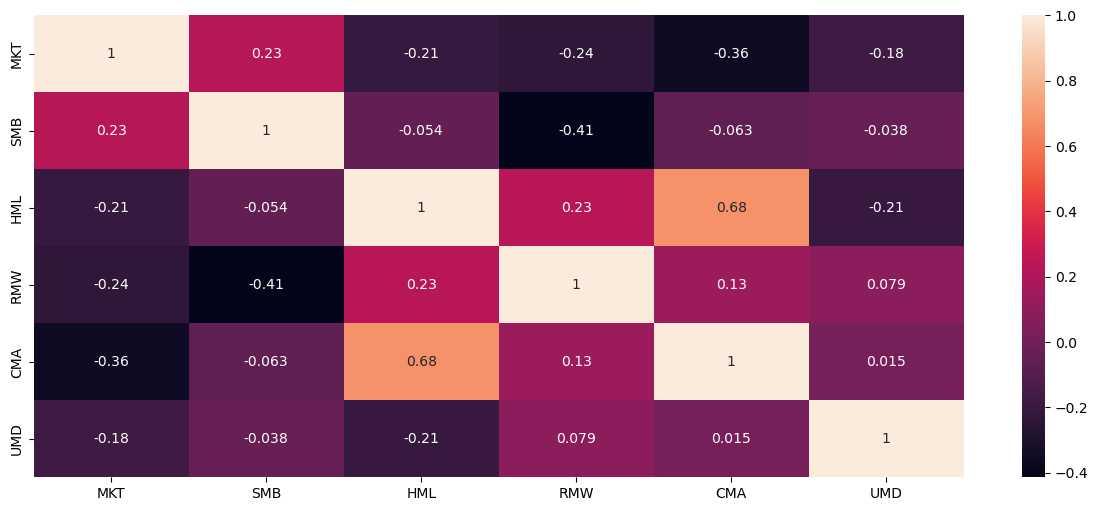

In [9]:
corr = factors.corr()
sns.heatmap(corr,annot=True)

### (a) Does the construction method succeed in keeping correlations small?

- In general, the factor correlations are small. However, there are a few factor pairs, such as (`HML`, `CMA`), (`SMB`, `RMW`), (`MKT`, `CMA`), having relatively high absolute correlations.

### (b) Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

- The `HML` factor has relatively high absolute correlations with other factors such as `CMA`, `RMW`, `UMD`, and `MKT`, so it is possible that `HML` is somehow redundant in the 5-factor model.

## 2.4
### Report the tangency weights for a portfolio of these 6 factors.

In [14]:
def computeTangencyPortfolio(df):
    """ Assuming monthly input data and annualized outputs"""

    mean = df.mean()*12
    sigma = df.std() * np.sqrt(12)
    cov = df.cov()*12
    cov_inv = np.linalg.inv(cov)
    
    w_t = pd.Series(cov_inv@mean,index=mean.index,name="TangencyPortfolio")
    w_t = w_t/sum(w_t)
    
    tangencyMean = w_t@mean
    tangencyVol = np.sqrt(w_t.T@cov@w_t)
    tangencySharpe = tangencyMean/tangencyVol
    
    return w_t,tangencyMean,tangencyVol,tangencySharpe

tangencyWt,tangencyMean,tangencyVol, tangencySharpe = computeTangencyPortfolio(factors)

In [15]:
print("Weights of Tangency Portfolio:")
tangencyWt.to_frame("Tangency Weights").sort_values('Tangency Weights',ascending = False)

Weights of Tangency Portfolio:


,Tangency Weights
CMA,0.369283
RMW,0.307353
MKT,0.203875
UMD,0.093818
SMB,0.087446
HML,-0.061776


### (a) Which factors seem most important? And Least?
- The `CMA`, `RMW`, and `MKT` factors seem the most important. More than 85% of the weights are allocated to them. The `HML` factor seems the least important as it has a negative weight.

### (b) Are the factors with low mean returns still useful?

In [16]:
pd.concat([summaryStats(factors)['Mean'],tangencyWt],axis =1).sort_values('Mean')

,Mean,TangencyPortfolio
SMB,0.011206,0.087446
HML,0.025324,-0.061776
CMA,0.032492,0.369283
RMW,0.046525,0.307353
UMD,0.060925,0.093818
MKT,0.084562,0.203875


- `CMA` and `RMW` have low mean returns, but they still have significant weights in the portfolio. However, `SMB` and `HML` may not be useful.

### (c)
#### Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

In [17]:
tangencyWt,tangencyMean,tangencyVol, tangencySharpe = computeTangencyPortfolio(factors[['MKT','SMB','HML','UMD']])

In [18]:
print("Weights of Tangency Portfolio:")
tangencyWt.to_frame("Tangency Weights").sort_values('Tangency Weights',ascending = False)

Weights of Tangency Portfolio:


,Tangency Weights
MKT,0.356440
HML,0.348903
UMD,0.300861
SMB,-0.006204


In [19]:
pd.concat([summaryStats(factors)['Mean'],tangencyWt],axis =1).dropna().sort_values('Mean')

,Mean,TangencyPortfolio
SMB,0.011206,-0.006204
HML,0.025324,0.348903
UMD,0.060925,0.300861
MKT,0.084562,0.356440


- The factors `HML`, `UMD`, and `MKT` have high tangency weights now. `SMB` still has a low weight.

### What do you conclude about the importance or unimportance of these styles?
- Since the `HML` factor generally has a high correlation with other factors, espescially with `CMA`, this factor plays a less important role in the tangency portfolio. As other correlated factors take higher weights than `HML`, in that sense, `HML` might be redundant.

# 3 Testing Modern LPMs

## 1. Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional regression tests.)

In [20]:
portfolios = pd.read_excel('factor_pricing_data.xlsx',sheet_name='portfolios (excess returns)',index_col='Date')

In [25]:
def linearRegression(seriesY,seriesX):
    
    mean =seriesY.mean()*12
    sharpe = mean/(seriesY.std()*(12**0.5))
    model = sm.OLS(seriesY,sm.add_constant(seriesX)).fit()
    rsq = model.rsquared
    
    beta = pd.DataFrame(index= [seriesY.name])
    
    for i,x in enumerate(seriesX):
         beta[x] = model.params[i+1]
    
    betaCols = [i+'Beta' for i in seriesX]
    beta = beta.rename(columns = dict(zip(beta.columns,betaCols)))
    
    treynor = mean/beta[beta.columns[0]]  # Treynor ratio: μ/MKTβ
    alpha = model.params[0]*12  # Annualized α
    information = alpha/(model.resid.std()*np.sqrt(12))  # Annualized information ratio
    
    RegressionStats = pd.DataFrame({'Mean Return':mean,'Sharpe Ratio':sharpe,'R Squared':rsq,\
                         'α':alpha, 'Information Ratio':information, 'Treynor':treynor},index= [seriesY.name])
    
    return pd.concat([RegressionStats,beta], axis =1)

## 3.1 AQR 4-factor model

In [22]:
aqr = factors[['MKT', 'HML', 'RMW', 'UMD']]

### (a) For each regression, report the estimated α and r-squared.

In [24]:
frames = []
for col in portfolios:
    p = linearRegression(portfolios[col],aqr)
    frames.append(p) 
AQRRegression = pd.concat(frames)
AQRRegression.T

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Mean Return,0.089693,0.099669,0.108840,0.119426,0.132925,0.062946,0.118245,0.074122,0.081545,0.098083,...,0.092398,0.090785,0.085521,0.111818,0.103863,0.088988,0.095899,0.048103,0.110258,0.050820
Sharpe Ratio,0.412541,0.660014,0.490980,0.700661,0.592263,0.252209,0.446060,0.357971,0.529226,0.437351,...,0.462944,0.452969,0.473165,0.596456,0.569968,0.413863,0.526738,0.192725,0.493620,0.239526
R Squared,0.341333,0.471088,0.307178,0.426698,0.272555,0.510315,0.617319,0.689702,0.560258,0.631763,...,0.586154,0.707433,0.756767,0.683464,0.643047,0.772044,0.685298,0.603615,0.812962,0.595904
α,0.009491,0.011434,0.019555,0.024178,0.035317,-0.032189,0.031788,-0.030329,-0.005510,-0.011724,...,0.002115,-0.017072,-0.013517,0.019527,0.002487,-0.022979,-0.008563,-0.056717,0.018242,-0.045176
Information Ratio,0.053788,0.104111,0.105981,0.187339,0.184497,-0.184306,0.193848,-0.262943,-0.053928,-0.086150,...,0.016476,-0.157477,-0.151638,0.185137,0.022844,-0.223835,-0.083839,-0.360927,0.188842,-0.334950
Treynor,0.107052,0.146377,0.138704,0.165106,0.180305,0.056362,0.094682,0.066563,0.108322,0.087683,...,0.094565,0.083035,0.082898,0.113938,0.109533,0.076764,0.097882,0.040084,0.088997,0.047921
MKTBeta,0.837838,0.680903,0.784688,0.723330,0.737220,1.116824,1.248868,1.113566,0.752802,1.118614,...,0.977081,1.093328,1.031640,0.981389,0.948235,1.159250,0.979743,1.200074,1.238895,1.060498
HMLBeta,0.178699,0.169841,0.206106,0.025183,0.249344,-0.035336,0.000177,0.265474,0.000889,0.049475,...,0.116515,0.189071,0.099153,-0.140767,0.080657,0.721895,0.479804,0.490751,0.327216,0.087573
RMWBeta,-0.006405,0.507359,0.494736,0.600586,0.657434,0.230797,-0.109524,0.177919,0.485108,0.564987,...,0.255496,0.352329,0.185132,0.347550,0.500334,0.087560,0.222779,0.062269,-0.401302,0.117101
UMDBeta,0.084119,0.045146,-0.087111,0.090319,-0.026824,-0.150169,-0.230768,-0.077390,0.013206,-0.202276,...,-0.117838,-0.094835,0.011102,-0.054203,-0.067775,-0.138145,-0.014815,-0.196719,-0.038805,-0.022131


### Calculate the mean-absolute-error of the estimated alphas, (one for each security, ˜ri.)

In [27]:
AQR_MAE = round(abs(AQRRegression['α']).mean(),6)
print(f'Mean Absolute Error for AQR factors: {AQR_MAE}')

Mean Absolute Error for AQR factors: 0.022995


### If the pricing model worked, should these alpha estimates be large or small? Why? Based on your MAE stat, does this seem to support the pricing model or not?

- If the pricing model was true, these $\alpha$ estimates should be small as most of the variation in excess returns should be explained by the AQR factors.
- We have a MAE stat of 2.30%, which is quite small, but there is still some variation of excess returns not explained by the AQR factor model.

## 3.2
### Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model. Report the MAE statistic for each of these models and compare it with the AQR Model MAE. Which model fits best?

In [28]:
ff3 = factors[['MKT', 'SMB', 'HML']]

frames = []
for col in portfolios:
    p = linearRegression(portfolios[col],ff3)
    frames.append(p) 
FF3Regression = pd.concat(frames)

In [30]:
FF3_MAE = round(abs(FF3Regression['α']).mean(),6)
print(f'Mean Absolute Error for FF-3 Factor Model: {FF3_MAE}')

Mean Absolute Error for FF-3 Factor Model: 0.0242


In [31]:
ff5 = factors[['MKT', 'SMB', 'HML', 'RMW', 'CMA']]
frames = []
for col in portfolios:
    p = linearRegression(portfolios[col],ff5)
    frames.append(p) 
FF5Regression = pd.concat(frames)
FF5_MAE = abs(FF3Regression['α']).mean()

In [33]:
FF5_MAE = round(abs(FF5Regression['α']).mean(),6)
print(f'Mean Absolute Error for FF-5 Factor Model: {FF5_MAE}')

Mean Absolute Error for FF-5 Factor Model: 0.031272


In [34]:
MAE_TS = pd.DataFrame({'MAE':[AQR_MAE,FF3_MAE,FF5_MAE]}, index = ["AQR","FF-3","FF-5"])
MAE_TS

,MAE
AQR,0.022995
FF-3,0.024200
FF-5,0.031272


- The AQR factor model fits the best as it has the lowest MAE stat.

## 3.3
### Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?

- Comparing to the Fama-French 3-factor model, the FF-5 factor model has a higher MAE stat, which means the additional two factors, `RMW` and `CMA`, may not be important.
- The AQR model adds the `UMD`(Momentum) factor, and has a lower MAE stat, so I think Fama and French should include the momentum factor.

## 3.4
### This does not matter for pricing, but report the average (across n estimations) of the time-series regression r-squared statistics. Do this for each of the three models you tested. Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?


In [35]:
AQR_RSq = AQRRegression['R Squared'].mean()
FF3_RSq = FF3Regression['R Squared'].mean()
FF5_RSq = FF5Regression['R Squared'].mean()

In [36]:
Average_R_Squared = pd.Series({'AQR':AQR_RSq,'FF3':FF3_RSq,'FF5':FF5_RSq})
Average_R_Squared.to_frame("Average R Squared")

,Average R Squared
AQR,0.577081
FF3,0.572516
FF5,0.597519


- The $R^2$ statistics of the three models are close. They are all below 0.6, and therefore they are not high enough to explain most of the variation in excess returns. Thus, these factor models may not be good in a Linear Factor Decomposition of the assets.

## 3.5
### We tested three models using the time-series tests (focusing on the time-series alphas.) Re-test these models, but this time use the cross-sectional test.

In [37]:
time_series_premia = (factors.mean()*12).to_frame('Time Series Premia')
time_series_premia.index = [x+"Beta" for x in time_series_premia.index]
time_series_premia

,Time Series Premia
MKTBeta,0.084562
SMBBeta,0.011206
HMLBeta,0.025324
RMWBeta,0.046525
CMABeta,0.032492
UMDBeta,0.060925


#### AQR Model

In [40]:
y = AQRRegression['Mean Return']
x = AQRRegression[['MKTBeta','HMLBeta','RMWBeta','UMDBeta']]
AQRRegressionCS = sm.OLS(y,x,missing='drop').fit()
AQR_CS_MAE = abs(AQRRegressionCS.resid).mean()
AQR_CS_premia = AQRRegressionCS.params.to_frame("AQR CS Premia")
AQR_CS_premia

,AQR CS Premia
MKTBeta,0.087644
HMLBeta,-0.039757
RMWBeta,0.044399
UMDBeta,0.053375


#### Fama French 3 Model

In [41]:
y = FF3Regression['Mean Return']
x = FF3Regression[['MKTBeta','SMBBeta','HMLBeta']]
FF3RegressionCS = sm.OLS(y,x,missing='drop').fit()
FF3_CS_MAE = abs(FF3RegressionCS.resid).mean()
FF3_CS_Premia = FF3RegressionCS.params.to_frame("FF3 CS Premia")
FF3_CS_Premia

,FF3 CS Premia
MKTBeta,0.101569
SMBBeta,-0.064615
HMLBeta,-0.017476


In [42]:
y = FF5Regression['Mean Return']
x = FF5Regression[['MKTBeta','SMBBeta','HMLBeta','RMWBeta','CMABeta']]
FF5RegressionCS = sm.OLS(y,x,missing='drop').fit()
FF5_CS_MAE = abs(FF5RegressionCS.resid).mean()
FF5_CS_Premia = FF5RegressionCS.params.to_frame("FF5 CS Premia")
FF5_CS_Premia

,FF5 CS Premia
MKTBeta,0.095697
SMBBeta,-0.057674
HMLBeta,-0.033504
RMWBeta,0.035899
CMABeta,-0.015156


### (a) Report the time-series premia of the factors (just their sample averages,) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?

In [43]:
pd.concat([time_series_premia,AQR_CS_premia,FF3_CS_Premia,FF5_CS_Premia],axis = 1).fillna('')

,Time Series Premia,AQR CS Premia,FF3 CS Premia,FF5 CS Premia
MKTBeta,0.084562,0.087644,0.101569,0.095697
SMBBeta,0.011206,,-0.064615,-0.057674
HMLBeta,0.025324,-0.039757,-0.017476,-0.033504
RMWBeta,0.046525,0.044399,,0.035899
CMABeta,0.032492,,,-0.015156
UMDBeta,0.060925,0.053375,,


- The time-series premia and the cross-sectionally estimated premia do not differ substantially except for the `SMB` factor.

### (b) Report the MAE of the cross-sectional regression residuals for each of the four models, (the υi.) How do they compare to the MAE of the time-series alphas?

In [44]:
MAE_CS = pd.Series([AQR_CS_MAE,FF3_CS_MAE, FF5_CS_MAE], index = MAE_TS.index)
MAE = pd.concat([MAE_TS,MAE_CS],axis = 1)
MAE.columns = ['Time Series MAE', 'Cross Section MAE']
MAE

,Time Series MAE,Cross Section MAE
AQR,0.022995,0.016395
FF-3,0.024200,0.015031
FF-5,0.031272,0.012982


- The MAE of cross-sectional regression residuals are generally lower than that of time-series alphas